# Data processing

Download, save, visualize and load dataset.



In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = "../../data/"
resolution = "5.625deg"

In [3]:
import platform
print(platform.python_version())

3.7.6


## 1. geopotential_500, temperature_850

### The signal

- Test: years 2017 and 2018
- Validation: year 2016
- Train: year 2015

In [9]:
def load_data(path, train_years=slice('2015', '2015'), val_years=slice('2016', '2016'), 
              test_years=slice('2017', '2018')):
    """
    Args:
        path: Path to nc files
        var: variable. Geopotential = 'z', Temperature = 't'
        years: slice for time window
    Returns:
        dataset: Concatenated dataset for 2017 and 2018
    """
    zpath = path + 'geopotential_500'
    tpath = path + 'temperature_850'
    
    z = xr.open_mfdataset(zpath+'/*.nc', combine='by_coords')['z']
    t = xr.open_mfdataset(tpath+'/*.nc', combine='by_coords')['t']
    
    try:
        # z = z.sel(level=500).drop('level')
        z = z.drop('level')
    except ValueError:
        pass

    try:
        # t = t.sel(level=850).drop('level')
        t = t.drop('level')
    except ValueError:
        pass
    
    dataset = xr.merge([z, t])
    
    return dataset.sel(time=train_years), dataset.sel(time=val_years), dataset.sel(time=test_years)
    

In [10]:
train, val, test = load_data(DATA_DIR + resolution + "/")

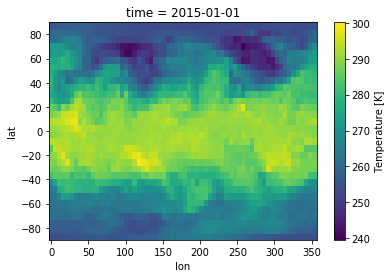

In [11]:
train.t[0].plot()

In [25]:
train.t[0]

<xarray.DataArray 't' (lat: 32, lon: 64)>
dask.array<getitem, shape=(32, 64), dtype=float32, chunksize=(32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    time     datetime64[ns] 2015-01-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

### The graphs

In order to use DeepSphere convolutional kernels, the input samples need to be:
- A 1d vector with the signal
- the Graph Laplacian 

/!\ Correspondence of the vertices

1. Sample the vertices  
    1.1. Create weight matrix  
    1.2. Get the indexes corresponding to the sampled vectors (for the signal)  
    
2. Order the vertices in a 1D vector (torch tensor)
3. Compute the Laplacian (torch tensor)

TO DO:
- Sampling method? -> equiangular
- Rasterizing method?
- Laplacian computation?

In [ ]:
# idk where to look for this

### Data generator

This data generator needs to provide:
- a whole minibatch 
- with normalized, shuffled data
- consisting in samples and labels
- having the correct format: X = (signal, laplacian), y = (signal + delta_t)


In [26]:
from collections import OrderedDict
from torch.utils.data import Dataset

In [13]:
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
train['z'].expand_dims({'level': generic_level}, 1)

<xarray.DataArray 'z' (time: 8760, level: 1, lat: 32, lon: 64)>
dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) int64 1
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [18]:


data = []
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
for var, levels in OrderedDict({'z': None, 't': None}).items():
    try:
        data.append(train[var].sel(level=levels))
    except ValueError:
        data.append(train[var].expand_dims({'level': generic_level}, 1))

In [19]:
data

[<xarray.DataArray 'z' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * level    (level) int64 1
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
 Attributes:
     units:          m**2 s**-2
     long_name:      Geopotential
     standard_name:  geopotential,
 <xarray.DataArray 't' (time: 8760, level: 1, lat: 32, lon: 64)>
 dask.array<transpose, shape=(8760, 1, 32, 64), dtype=float32, chunksize=(8760, 1, 32, 64), chunktype=numpy.ndarray>
 Coordinates:
   * level    (level) int64 1
   * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
   * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
   * time     (time) datetime64[ns] 2015-01-01 ... 

In [22]:
xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')

<xarray.DataArray 'z' (time: 8760, lat: 32, lon: 64, level: 2)>
dask.array<transpose, shape=(8760, 32, 64, 2), dtype=float32, chunksize=(8760, 32, 64, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
  * level    (level) int64 1 1

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.dataset = dataset
        self.variable_dict = variable_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in variable_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)